In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math as math
from collections import OrderedDict, defaultdict

In [2]:
data = pd.read_csv("faithful.txt", sep= "     ", header=None)

data.columns = ["Index", "Eruptions", "Waiting"]

data

C:\Users\super\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,Index,Eruptions,Waiting
0,1,3.600,79
1,2,1.800,54
2,3,3.333,74
3,4,2.283,62
4,5,4.533,85
...,...,...,...
267,268,4.117,81
268,269,2.150,46
269,270,4.417,90
270,271,1.817,46


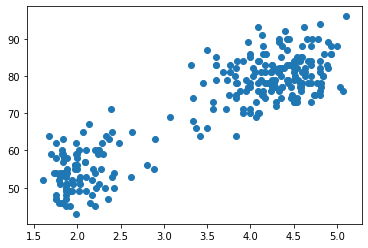

In [3]:
plt.scatter(data['Eruptions'],data['Waiting'])

In [4]:
training_data = data[:250]
testing_data = data[250:]

train_X = training_data[["Eruptions"]].values
train_Y = training_data[["Waiting"]].values

test_X = testing_data[["Eruptions"]].values
test_Y = testing_data[["Waiting"]].values

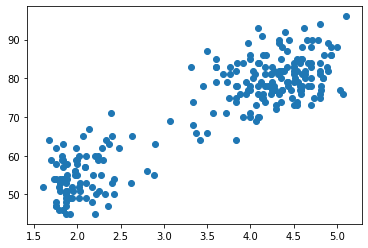

In [5]:
plt.scatter(training_data['Eruptions'],training_data['Waiting'])

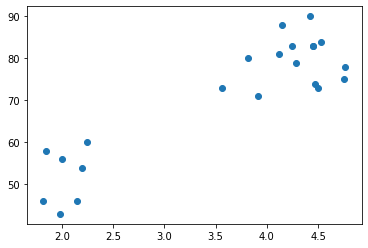

In [6]:
plt.scatter(testing_data['Eruptions'],testing_data['Waiting'])

In [7]:
def EM_Train(x,clusterSize = 2):
    #By above data visualization we know we need 2 clusters
    #Hence k=2
    k = clusterSize
    n = x.shape[0]
    p = x.shape[1]

    phi = np.random.rand(k,p)
    total = np.sum(phi)
    phi = phi/total #sum of all phi value = 1
    mu = np.random.rand(k,p)
    sigma = np.random.rand(k,p)    
    w = np.ndarray(shape=(n,k,p))
    preW = np.ndarray(shape=(p))
    apple = 0
    isConverged = False
   # E step 
    while not isConverged:
        if apple >= 1000:
            break
        apple+=1

        #Calculation of Wij
        sum_of_all_probability = np.zeros((n,1,p))
        probability = np.zeros((n,k,p))
        for i in range(n):
            for j in range(k):
                dij = x[i] - mu[j] 
                dijSquare = - ( dij.T * dij )
                sigSquare = 2 * sigma[j]**2
                tempExp = np.exp( dijSquare / sigSquare )
                constant = 1 / ( (2*math.pi)**(p/2) * sigma[j] )
                probability[i,j] = ( constant * tempExp * phi[j] )
                sum_of_all_probability[i] += probability[i,j]

        preW = np.copy(w)
        for i in range(n):
                for j in range(k):
                    w[i,j] = probability[i,j] / sum_of_all_probability[i]
        
        if (preW == w).all():
            isConverged = True
     # M step   
        #Calculation of mu sigma and phi
        for j in range(k):
            sum_W_X_MU = 1
            sum_W_X = 1
            sum_W = 2

            #Calculation of mu
            for i in range(n):
                sum_W_X +=  w[i,j] * x[i]
                sum_W += w[i,j]  
            mu[j] = sum_W_X / sum_W
            
            #Calculation of sigma
            for i in range(n):
                sum_W_X_MU += w[i,j] * (x[i]-mu[j])**2                
            sigma[j] = ( sum_W_X_MU / sum_W )**0.5
                
            #Calculation of phi
            phi[j] = sum_W / n
            
    print ("Number of Iterations: ",apple)    
    return w, mu, sigma, phi

In [21]:
def Find_Probability(x, mu, sigma, phi, clusterSize=2):
    k = clusterSize
    n = x.shape[0]
    p = x.shape[1]
    w = np.ndarray(shape=(n,k,p))
    sum_of_all_probability = np.zeros((n,1,p))
    probability = np.zeros((n,k,p))
    
    for i in range(n):
        for j in range(k):
            dij = x[i] - mu[j] 
            dijSquare = - ( dij.T * dij )
            sigSquare = 2 * sigma[j]**2
            tempExp = np.exp( dijSquare / sigSquare )
            constant = 1 / ( (2*math.pi)**(p/2) * sigma[j] )
            probability[i,j] = ( constant * tempExp * phi[j] )
            sum_of_all_probability[i] += probability[i,j]
    
    preW = np.copy(w)       
    for i in range(n):
            for j in range(k):
                w[i,j] = probability[i,j] / sum_of_all_probability[i]
    return w

In [22]:
def CreateDict(w):
    dic = defaultdict(list)
    i = 0
    for c in w:
        if c[0] > c[1]:
            dic[0].append(i)
        else:
            dic[1].append(i)
        i += 1 
    return dic

def PlotGraph(data, dic):
    for rowind in range(0, len(data)):
        temp = data.iloc[[rowind]]
        if rowind in dic[0]:
            plt.plot(temp["Eruptions"],temp["Waiting"], 'b+')
        else:
            plt.plot(temp["Eruptions"],temp["Waiting"], 'r+')

Number of Iterations:  67


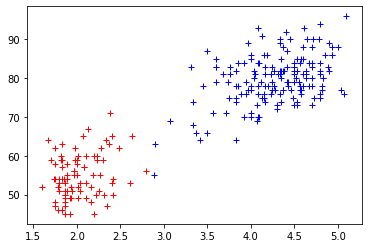

In [23]:
w, mu, sigma, phi = EM_Train(train_X)
trainingCluster = CreateDict(w)
PlotGraph(training_data, trainingCluster)

In [24]:
#Now Dividing Data into Clusters
train_clutster_1 = training_data.loc[ training_data["Index"].isin( trainingCluster[0] ) ]
train_clutster_2 = training_data.loc[ training_data["Index"].isin( trainingCluster[1] ) ]

train_X_clutster_1 = train_clutster_1[["Eruptions"]].values
train_Y_clutster_1 = train_clutster_1[["Waiting"]].values

train_X_clutster_2 = train_clutster_2[["Eruptions"]].values
train_Y_clutster_2 = train_clutster_2[["Waiting"]].values

#For Each cluster Finding the theta value
#Basically applying linear regression for each cluster
def Linear_Train(training_data_X, training_data_Y):
    xT = np.transpose(training_data_X)
    xTx = np.matmul ( xT, training_data_X )
    inverse_xTx = np.linalg.inv ( xTx )
    xTy = np.matmul ( xT, training_data_Y )
    theta_function =  np.matmul (inverse_xTx, xTy)
    return theta_function

def Cal_Error(validating_data_X, validating_data_Y, theta_function):
    #Now Validation of Data
    error_function = ( np.matmul( validating_data_X, theta_function ) - validating_data_Y ) ** 2
    mean_square_error = np.sum(error_function)
    root_mean_square_error = np.sqrt(mean_square_error) / np.size(error_function)
    return root_mean_square_error

theta_cluster_1 = Linear_Train(train_X_clutster_1,train_Y_clutster_1)
theta_cluster_2 = Linear_Train(train_X_clutster_2,train_Y_clutster_2)

In [25]:
rmse_1 = Cal_Error(train_X_clutster_1,train_Y_clutster_1,theta_cluster_1)
rmse_2 = Cal_Error(train_X_clutster_2,train_Y_clutster_2,theta_cluster_2)

print ("Root Mean Square Error of Cluster 1 :",rmse_1)
print ("Root Mean Square Error of Cluster 2 :",rmse_2)

Root Mean Square Error of Cluster 1 : 1.050438846213876
Root Mean Square Error of Cluster 2 : 0.8947392441108463


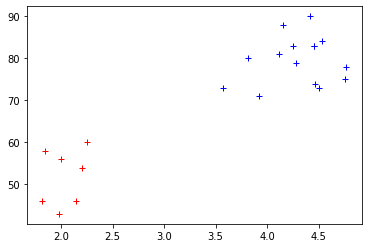

In [31]:
predict_w = Find_Probability(test_X, mu, sigma, phi)
predictCluster  = CreateDict(predict_w)

predict_Y = np.ndarray((test_Y.shape[0], test_Y.shape[1]))

for rowind in range(len(test_X)):
    temp = test_X[rowind,:]
    if rowind in predictCluster[0]:
        predict_Y[rowind] = np.matmul(temp, theta_cluster_1)
    else:
        predict_Y[rowind] = np.matmul(temp, theta_cluster_2)
        
PlotGraph(testing_data, predictCluster)

Text(0, 0.5, 'Waiting')

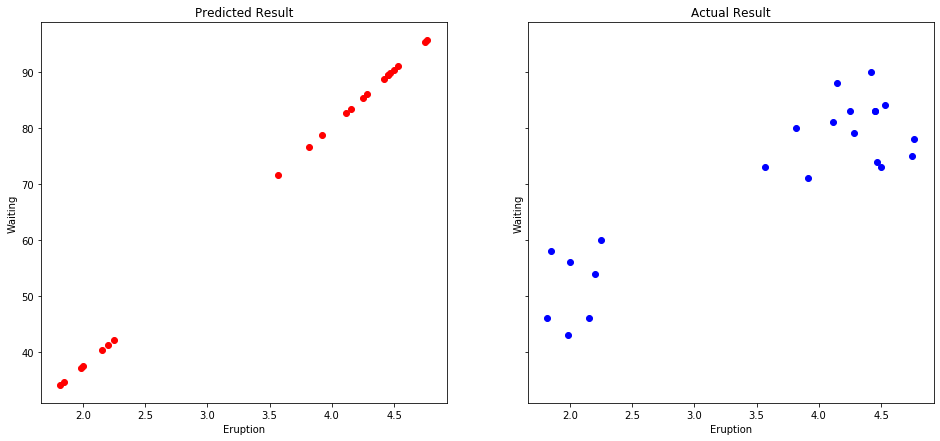

In [32]:
fig, arr = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True)

fig.set_figwidth(16)
fig.set_figheight(7)

arr[0].scatter (test_X[:,0], predict_Y, c='r' )
arr[0].set_title('Predicted Result')
arr[0].set_xlabel('Eruption')
arr[0].set_ylabel('Waiting')

arr[1].scatter (test_X[:,0], test_Y, c='b' )
arr[1].set_title('Actual Result')
arr[1].set_xlabel('Eruption')
arr[1].set_ylabel('Waiting')

Text(0.5, 1.0, 'Actual Result')

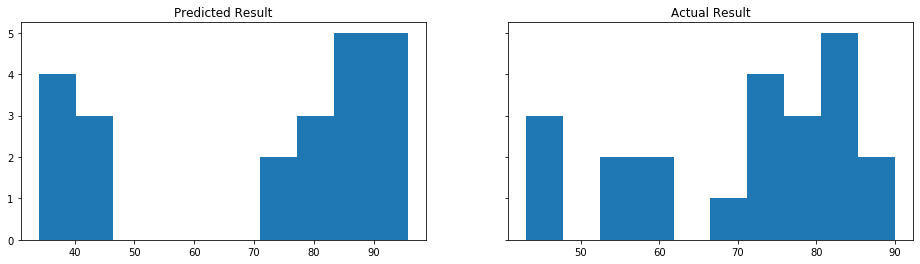

In [28]:
fig, arr = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True)

fig.set_figwidth(16)
fig.set_figheight(4)

arr[0].hist(predict_Y)
arr[0].set_title('Predicted Result')

arr[1].hist(test_Y)
arr[1].set_title('Actual Result')